# Реализация переводчика на архитектуре Transformer
(перевод текстов с английского на русский язык)

In [64]:
import gzip
import heapq
import math
import os
import platform
import random
import shutil
import sys
import time
import zipfile
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import spacy
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import xml.etree.ElementTree as ET
import youtokentome as yttm

In [65]:
SEED = 1234

random.seed(SEED)
#np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [66]:
print(f'Версия Python: {platform.python_version()}')
print(f'Платформа: {platform.platform()}')
print(f'Версия torch: {torch.__version__}')

Версия Python: 3.11.5
Платформа: Windows-10-10.0.22631-SP0
Версия torch: 2.1.1


In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

NVIDIA GeForce RTX 3090


Параметры формирования датасета (загрузка, токенизация), и словарей

In [68]:
dataset_name = 'WikiMatrix'   # имя датасета для загрузки

ru2en_mode = False            # флаг формирования датасета ru2en вместо en2ru
data_lower = False             # флаг приведения предложений к нижнему регистру
tokenize_bpe = False          # флаг токенизации с помощью метода BPE

MAX_LEN_SRC = 200             # ограничение длины src (токенов при токенизации SpaCy, слов при токенизации BPE)
MAX_LEN_TRG = 200             # ограничение длины trg (токенов при токенизации SpaCy, слов при токенизации BPE)

# частота слова для попадания в словарь (при токенизации регулярками / spaCy)
min_freq_src = 3
min_freq_trg = 3

# максимальный размер словаря
MAX_VOCAB_SIZE_SRC = 25000
MAX_VOCAB_SIZE_TRG = 25000

BATCH_SIZE = 16

## Загрузчик данных

### Загрузка и формирование датасетов en-ru с OPUS

In [69]:
def load_dataset(dataset_name, mode='tmx', val_part = 0, test_part = 0, ru2en_mode = False):
    '''
    функция принимает на вход имя датасета из доступных, загружает указанный датасет
    и возвращает обучающую, валидационную и тестовые выборки в виде списков с кортежами (src, trg)
    
    параметры:
    dataset_name - имя датасета для загрузки
    mode - режим загрузки: raw (из отдельных xml-файлов en и ru) и tmx (из xml-файла с парами предожений)
    ru2en_mode - если True, то перевод с русского на английский
    val_part - размер валидационной выборки (0-1)
    test_part - размер тестовой выборки (0-1)

    доступные датасеты:
    wikipedia_health
    ada83
    wikimedia
    WikiMatrix
    NLLB
    '''
    
    assert val_part >= 0, 'Доля валидационной выборки не может быть меньше 0'
    assert val_part <= 1, 'Доля валидационной выборки не может быть больше 1'
    assert test_part >= 0, 'Доля тестовой выборки не может быть меньше 0'
    assert test_part <= 1, 'Доля тестовой выборки не может быть больше 1'
    assert val_part + test_part <= 1, 'Доля тестовой и валидационной выборок не может быть больше 1'
    
    def bar_progress(current, total, width=80):
        progress_message = "Downloading: %d%% [%.2f / %.2f] MiB" % (current / total * 100, current/1024/1024, total/1024/1024)
        sys.stdout.write("\r" + progress_message)
        sys.stdout.flush()
    
    def download_archive(url, dataset_path, file_name, bar=bar_progress):
        if file_name not in os.listdir(dataset_path):
            print(f'Загрузка архива {file_name} датасета {dataset_name}')
            wget.download(url, os.path.join(dataset_path, file_name), bar=bar_progress)
            print()
    
    datasets_url = {'wikipedia_health':{'url_en':'https://object.pouta.csc.fi/OPUS-ELRC-3075-wikipedia_health/v1/raw/en.zip',
                                        'url_ru':'https://object.pouta.csc.fi/OPUS-ELRC-3075-wikipedia_health/v1/raw/ru.zip',
                                        'url_tmx':'https://object.pouta.csc.fi/OPUS-ELRC-3075-wikipedia_health/v1/tmx/en-ru.tmx.gz'},
                    'ada83':{'url_en':'https://object.pouta.csc.fi/OPUS-ada83/v1/raw/en.zip',
                             'url_ru':'https://object.pouta.csc.fi/OPUS-ada83/v1/raw/ru.zip',
                             'url_tmx':'https://object.pouta.csc.fi/OPUS-ada83/v1/tmx/en-ru.tmx.gz'},
                    'wikimedia':{'url_en':'https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/raw/en.zip',
                                 'url_ru':'https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/raw/ru.zip',
                                 'url_tmx':'https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/tmx/en-ru.tmx.gz'},
                    'WikiMatrix':{'url_en':'https://object.pouta.csc.fi/OPUS-WikiMatrix/v1/raw/en.zip',
                                 'url_ru':'https://object.pouta.csc.fi/OPUS-WikiMatrix/v1/raw/ru.zip',
                                 'url_tmx':'https://object.pouta.csc.fi/OPUS-WikiMatrix/v1/tmx/en-ru.tmx.gz'},
                    'NLLB':{'url_en':'https://object.pouta.csc.fi/OPUS-NLLB/v1/raw/en.zip',
                            'url_ru':'https://object.pouta.csc.fi/OPUS-NLLB/v1/raw/ru.zip',
                            'url_tmx':'https://object.pouta.csc.fi/OPUS-NLLB/v1/tmx/en-ru.tmx.gz'}
                    }

    if 'datasets' not in os.listdir():
        os.mkdir('datasets')
    dataset_path = os.path.join('datasets', dataset_name)
    if dataset_name not in os.listdir('datasets'):
        os.mkdir(dataset_path)

    if mode == 'raw':
        
        src_url = datasets_url[dataset_name]['url_en']
        trg_url = datasets_url[dataset_name]['url_ru']
        
        src = []
        trg = []    

        for trg_flag, url in enumerate([src_url, trg_url]):
            
            file_name = url.split('/')[-1]
            download_archive(url, dataset_path, file_name)      
            
            # распаковка архивов zip
            with zipfile.ZipFile(os.path.join(dataset_path, file_name), 'r') as zip_file:
                extracted_file = zip_file.namelist()
                extracted_file = [path for path in extracted_file if path[-4:] == '.xml'][-1]
                zip_file.extract(extracted_file, path='temp')
                extracted_file = os.path.join('temp', extracted_file)
                print(f'Архив {file_name} датасета {dataset_name} распакован в {extracted_file}')
   
                # парсинг xml-файлов
                print(f'Парсинг xml-файла {extracted_file[5:]}')
                tree = ET.parse(extracted_file)
                root = tree.getroot()
                for i, item in enumerate(root):
                    if trg_flag == 0:
                        src.append(item.text)
                    else:
                        trg.append(item.text)
                    
                    if i+1%1000 == 0:
                        print(f'Parsing: {(i+1)*100//len(root)}% [{i+1:,} / {len(root):,}] items', end="\r")
                print(f'Parsing: {(i+1)*100//len(root)}% [{i+1:,} / {len(root):,}] items', end="\r")
                print('\n', end="")
                print()

            # удаление временных файлов и каталогов
            os.remove(extracted_file)
            os.removedirs(os.path.split(extracted_file)[0])    

        assert len(src) == len(trg), 'Списки предложеий на разных языках должны быть одинаковой длины'
        
        dataset_row = []
        for i in range(len(src)):
            dataset_row.append((src[i], trg[i]))

    elif mode == 'tmx':
        
        url = datasets_url[dataset_name]['url_tmx']
        file_name = url.split('/')[-1]
        download_archive(url, dataset_path, file_name)
        
        # распаковка архива gz
        if 'temp' not in os.listdir('.'):
            os.mkdir('temp')
        with gzip.open(os.path.join(dataset_path, file_name), 'rb') as f_in:
            extracted_file = os.path.join('temp', '.'.join(file_name.split('.')[:-1]))
            with open(extracted_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
                print(f'Архив {file_name} датасета {dataset_name} распакован в {extracted_file}')

        # парсинг xml-файла
        print(f'Парсинг xml-файла {extracted_file[5:]}')
        dataset_row = []
        tree = ET.parse(extracted_file)
        root = tree.getroot()
        for i, pair in enumerate(root[1]):
            try:
                src = pair[0][0].text
                trg = pair[1][0].text
                if (src is not None) and ((trg is not None)):
                    if src[-1] == ' ':
                        src = src[:-1]
                    if trg[-1] == ' ':
                        trg = trg[:-1]
                    dataset_row.append((src, trg))
            except:
                pass

            if i+1%1000 == 0:
                print(f'Parsing: {(i+1)*100//len(root[1])}% [{i+1:,} / {len(root[1]):,}] items', end="\r")
        print(f'Parsing: {(i+1)*100//len(root[1])}% [{i+1:,} / {len(root[1]):,}] items', end="\r")
        print('\n', end="")
        print()
        
        # удаление временных файлов и каталогов
        os.remove(extracted_file)
        os.removedirs(os.path.split(extracted_file)[0]) 

    else:
        print('Неверно указан режим загрузки')
        return None
    
    if ru2en_mode == True:
        dataset_row = [(ru, en) for en, ru in dataset_row]
    print(f'Сформирован датасет из {len(dataset_row)} пар предложений')
    print()

    dataset_size = len(dataset_row)
    val_len = int(val_part*dataset_size)
    test_len = int(test_part*dataset_size)
    train_len = dataset_size - val_len - test_len
    
    if train_len < dataset_size:
        random.shuffle(dataset_row)

    dataset_row_splited = []
    if train_len > 0:
        dataset_row_splited.append(dataset_row[:train_len])
        print(f'Размер обучающей выборки: {train_len}')
    if val_len > 0:
        dataset_row_splited.append(dataset_row[train_len:train_len+val_len])
        print(f'Размер валидационной выборки: {val_len}')
    if test_len > 0:
        dataset_row_splited.append(dataset_row[train_len+val_len:train_len+val_len+test_len])
        print(f'Размер тестовой выборки: {test_len}')
    
    return tuple(dataset_row_splited)

train_data_raw, valid_data_raw, test_data_raw = load_dataset(dataset_name, mode='tmx',
                                                             val_part=0.05, test_part=0.05,
                                                             ru2en_mode=False)  

Архив en-ru.tmx.gz датасета WikiMatrix распакован в temp\en-ru.tmx
Парсинг xml-файла en-ru.tmx
Parsing: 100% [1,661,908 / 1,661,908] items

Сформирован датасет из 1661907 пар предложений

Размер обучающей выборки: 1495717
Размер валидационной выборки: 83095
Размер тестовой выборки: 83095


In [70]:
print('Максимальная длина переводимого предожения (слов):',
       max([(len(src.split())) for src, trg in train_data_raw] +
           [(len(src.split())) for src, trg in valid_data_raw] +
           [(len(src.split())) for src, trg in test_data_raw]
           )
      )

print('Максимальная длина референсного перевода (слов):',
       max([(len(trg.split())) for src, trg in train_data_raw] +
           [(len(trg.split())) for src, trg in valid_data_raw] +
           [(len(trg.split())) for src, trg in test_data_raw]
           )
      )

Максимальная длина переводимого предожения (слов): 7114
Максимальная длина референсного перевода (слов): 17507


### Препроцессинг датасета и формирование словарей с помощью BPE

Приведение датасета к нижнему регистру (опционально)

In [71]:
if (tokenize_bpe == True) and (data_lower == True):
    train_data_raw = [(src.lower(), trg.lower()) for src, trg in train_data_raw]
    valid_data_raw = [(src.lower(), trg.lower()) for src, trg in valid_data_raw]
    test_data_raw  = [(src.lower(), trg.lower()) for src, trg in test_data_raw]

Ограничение длины src и trg (опционально)

In [72]:
if tokenize_bpe == True:
    # ограничение длины предложения, разбивка слов пробелами
    train_data_raw = [[' '.join(src.split()[:MAX_LEN_SRC]), ' '.join(trg.split()[:MAX_LEN_TRG])] for src, trg in train_data_raw]
    valid_data_raw = [[' '.join(src.split()[:MAX_LEN_SRC]), ' '.join(trg.split()[:MAX_LEN_TRG])] for src, trg in valid_data_raw]
    test_data_raw  = [[' '.join(src.split()[:MAX_LEN_SRC]), ' '.join(trg.split()[:MAX_LEN_TRG])] for src, trg in test_data_raw]   

Формирование словаря для BPE

In [73]:
if tokenize_bpe == True:
    '''
    основной модуль yttm не на python, данные в библиотеку подаются через текстовый файл
    все текстовые данные сохраняем в файл TRAIN_TEXTS_FILENAME
    модель читает данные из этого файла и складывает словарь замен в файл BPE_MODEL_FILENAME
    '''
    def save_texts_to_file(texts, out_file):
        with open(out_file, 'w') as outf:
            outf.write('\n'.join(texts))

    TRAIN_SRC_FILENAME = './datasets/src_bpe_train.txt'
    TRAIN_TRG_FILENAME = './datasets/trg_bpe_train.txt'
    save_texts_to_file([row[0] for row in train_data_raw], TRAIN_SRC_FILENAME)
    save_texts_to_file([row[1] for row in train_data_raw], TRAIN_TRG_FILENAME)

    if 'models' not in os.listdir():
        os.mkdir('models')

    BPE_SRC_MODEL_FILENAME = './models/src.yttm'
    BPE_TRG_MODEL_FILENAME = './models/trg.yttm'
    yttm.BPE.train(data=TRAIN_SRC_FILENAME, model=BPE_SRC_MODEL_FILENAME, vocab_size=MAX_VOCAB_SIZE_SRC, pad_id = 1, unk_id = 0) # 6346      исх
    yttm.BPE.train(data=TRAIN_TRG_FILENAME, model=BPE_TRG_MODEL_FILENAME, vocab_size=MAX_VOCAB_SIZE_TRG, pad_id = 1, unk_id = 0) # 14349     исх

    # создание экземпляра класса BPE и передача ему пути к файлу с обученной моделью (словарю)
    SRC = yttm.BPE(BPE_SRC_MODEL_FILENAME)
    TRG = yttm.BPE(BPE_TRG_MODEL_FILENAME)

    print(f'Размер словаря src: {SRC.vocab_size()}')
    print('Словарь src: ' + ' '.join(SRC.vocab()))
    print(f'Размер словаря trg: {TRG.vocab_size()}')
    print('Словарь trg: ' + ' '.join(TRG.vocab()))
    print()

    sentense = train_data_raw[0][0]
    print(f'BPE кодирование строки: "{sentense}":')
    print(SRC.encode(sentense, bos = True, eos=True))
    print(f'BPE декодирование строки:')
    print(''.join(SRC.decode(SRC.encode(sentense, bos = True, eos=True), ignore_ids=[0,1,2,3])))

### Токенизация текстов с помощью spaCy и формирование словарей

Токенизация текстов

In [74]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_ru(text):
    """
    Tokenizes Russian text from a string into a list of strings
    """
    return [tok.text for tok in spacy_ru.tokenizer(text)]

def tokenize_raw_data(row_data, tokenize_src, tokenize_trg, lower=False, max_token_src=None, max_token_trg=None):
    """
    Tokenizes a list of tuple of src and trg
    """
    data_tokenized = []

    for pair in row_data:
        src = tokenize_src(pair[0])
        trg = tokenize_trg(pair[1])

        if (src!=[]) & (trg!=[]):
            src = src[:max_token_src]
            trg = trg[:max_token_trg]
            
            if lower == True:
                src = [token.lower() for token in src]
                trg = [token.lower() for token in trg]
            
            data_tokenized.append((src, trg))
   
    return data_tokenized

In [75]:
if tokenize_bpe == False:
    try:
        spacy_en = spacy.load('en_core_web_sm')  # используется для токенизации предложений
        spacy_ru = spacy.load('ru_core_news_sm')
    except:
        !spacy download en_core_web_sm
        !spacy download ru_core_news_sm
        spacy_en = spacy.load('en_core_web_sm')
        spacy_ru = spacy.load('ru_core_news_sm')

    tokenize_src = tokenize_en if ru2en_mode == False else tokenize_ru
    tokenize_trg = tokenize_ru if ru2en_mode == False else tokenize_en

    train_tokenized = tokenize_raw_data(train_data_raw, tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)
    valid_tokenized = tokenize_raw_data(valid_data_raw, tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)
    test_tokenized  = tokenize_raw_data(test_data_raw,  tokenize_src, tokenize_trg, lower=data_lower, max_token_src=MAX_LEN_SRC, max_token_trg=MAX_LEN_TRG)    
    
    print(f"Размер обучающей выборки: {len(train_tokenized)}")
    print(f"Размер валидационной выборки: {len(valid_tokenized)}")
    print(f"Размер тестовой выборки: {len(test_tokenized)}")


Размер обучающей выборки: 1495717
Размер валидационной выборки: 83095
Размер тестовой выборки: 83095


Формирование словарей

In [76]:
class vocab():
    def __init__(self, data_tokenized, min_freq: int = 1, max_vocab=None, unk_token = '<UNK>',
                 pad_token = '<PAD>', init_token = '<BOS>', eos_token = '<EOS>'):
     
        tokens_list = []
        for row in data_tokenized:
            tokens_list.extend(row)
        tokens_list = sorted(tokens_list)

        counter = Counter(tokens_list)

        sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        sorted_by_freq_tokens = [i[0] for i in sorted_by_freq_tuples if i[1] >= min_freq]
        
        specials = [unk_token, pad_token, init_token, eos_token]
        sorted_by_freq_tokens = specials + sorted_by_freq_tokens
    
        if max_vocab:
            sorted_by_freq_tokens = sorted_by_freq_tokens[:max_vocab]
        
        self.itos = sorted_by_freq_tokens

        def default_value():
            return 0
        
        self.stoi = defaultdict(default_value) 
        for token_id, token in enumerate(self.itos):
            self.stoi[token] = token_id

    def vocab_size(self):
        return len(self.itos)
    
    def subword_to_id(self, subword):
        return SRC.stoi[subword]

if tokenize_bpe == False:

    SRC = vocab([itm[0] for itm in train_tokenized], min_freq=min_freq_src, max_vocab=MAX_VOCAB_SIZE_SRC)
    TRG = vocab([itm[1] for itm in train_tokenized], min_freq=min_freq_trg, max_vocab=MAX_VOCAB_SIZE_TRG)

    print(f"Уникальные токены в словаре SRC: {SRC.vocab_size()}")
    print(f"Уникальные токены в словаре TRG: {TRG.vocab_size()}")

Уникальные токены в словаре SRC: 25000
Уникальные токены в словаре TRG: 25000


### Формирование датасета с помощью Dataset

In [77]:
class DatasetSeq2Seq(Dataset):
    """
    на вход подается нетокенизированный датасет и словарь BPE
    или токенизированный датасет и словари token2id
    токены в датасете преобразуются в id
    """
    def __init__(self, data, src2idx, trg2idx):
            
        self.BPE_mode = True if type(src2idx).__name__ == 'BPE' else False       
        self.src_list = []
        self.trg_list = []

        if self.BPE_mode == True:
            for i in range(len(data)):
                self.src_list.append(src2idx.encode(data[i][0], bos=True, eos=True))
                self.trg_list.append(trg2idx.encode(data[i][1], bos=True, eos=True))
        else:
            for i in range(len(data)):
                self.src_list.append([src2idx['<BOS>']] + [src2idx[i] for i in data[i][0]] + [src2idx['<EOS>']])
                self.trg_list.append([src2idx['<BOS>']] + [trg2idx[i] for i in data[i][1]] + [src2idx['<EOS>']])

        assert len(self.src_list) == len(self.trg_list), 'Списки src и trg должны быть одинаковой длины'

        self.len = len(self.src_list)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return {'src': self.src_list[index],
                'trg': self.trg_list[index]}

In [78]:
if tokenize_bpe == True:
    train_data = DatasetSeq2Seq(train_data_raw, SRC, TRG)
    valid_data = DatasetSeq2Seq(valid_data_raw, SRC, TRG)
    test_data = DatasetSeq2Seq(test_data_raw, SRC, TRG)

elif tokenize_bpe == False:
    train_data = DatasetSeq2Seq(train_tokenized, SRC.stoi, TRG.stoi)
    valid_data = DatasetSeq2Seq(valid_tokenized, SRC.stoi, TRG.stoi)
    test_data = DatasetSeq2Seq(test_tokenized,   SRC.stoi, TRG.stoi)

print(f"Размер обучающей выборки: {train_data.__len__()}")
print(f"Размер валидационной выборки: {valid_data.__len__()}")
print(f"Размер тестовой выборки: {test_data.__len__()}")

Размер обучающей выборки: 1495717
Размер валидационной выборки: 83095
Размер тестовой выборки: 83095


## Формирование батча

Функция collate для формирования батча с помощью DataLoader

In [79]:
def collate_fn(input_data):
    src = []
    trg = []

    for item in input_data:
        src.append(torch.as_tensor(item['src']))
        trg.append(torch.as_tensor(item['trg']))

    src = pad_sequence(src, batch_first=True, padding_value=1)
    trg = pad_sequence(trg, batch_first=True, padding_value=1)

    batch = {'src': src, 'trg': trg}

    return batch

In [80]:
train_iterator = DataLoader(train_data, BATCH_SIZE, shuffle=True,  collate_fn=collate_fn, drop_last = False)
valid_iterator = DataLoader(valid_data, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last = False)
test_iterator =  DataLoader(test_data,  BATCH_SIZE, shuffle=False, collate_fn=collate_fn, drop_last = False)

## Архитектура модели (Трансформер)

In [81]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [82]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [83]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [84]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [85]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [86]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [87]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)

        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Инициализация модели

In [88]:
INPUT_DIM = SRC.vocab_size()
OUTPUT_DIM = TRG.vocab_size()
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_MAX_LENGHT = max([i['src'].shape[1] for i in train_iterator] +
                     [i['src'].shape[1] for i in valid_iterator] +
                     [i['src'].shape[1] for i in test_iterator])
TRG_MAX_LENGHT = max([i['trg'].shape[1] for i in train_iterator] +
                     [i['trg'].shape[1] for i in valid_iterator] +
                     [i['trg'].shape[1] for i in test_iterator])

SRC_PAD_IDX = SRC.subword_to_id('<PAD>')
TRG_PAD_IDX = TRG.subword_to_id('<PAD>')

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              max_length=SRC_MAX_LENGHT)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=TRG_MAX_LENGHT)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Количество параметров модели

In [89]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель имеет {count_parameters(model):,} обучаемых параметров')

Модель имеет 23,282,088 обучаемых параметров


Инициализация весов

In [90]:
# Xavier
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

## Оптимизатор

In [91]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

##  Функция потерь

In [92]:
# CrossEntropyLoss, потери, рассчитанные по токенам <PAD>, игнорируются
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

## Трейн луп

In [93]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch['src']
        trg = batch['trg']

        src = src.to(device)
        trg = trg.to(device)
            
        optimizer.zero_grad()
            
        output, _ = model(src, trg[:,:-1])
            
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
            
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
        optimizer.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [94]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch['src']
            trg = batch['trg']

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [95]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [96]:
def train_eval_loop(model, train_iterator, valid_iterator, N_EPOCHS=10, CLIP = 1):

    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):
        
        try:
        
            start_time = time.time()
            
            train_iterator = DataLoader(train_data, 
                                        BATCH_SIZE, 
                                        shuffle=True, 
                                        collate_fn=collate_fn,
                                        drop_last = False,
                                        )

            train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
            valid_loss = evaluate(model, valid_iterator, criterion)
            
            end_time = time.time()
            
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'model_translator.pt')
            
            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        
    return None

In [97]:
train_eval_loop(model, train_iterator, valid_iterator, N_EPOCHS=6)

Epoch: 01 | Time: 24m 41s
	Train Loss: 4.097 | Train PPL:  60.169
	 Val. Loss: 3.756 |  Val. PPL:  42.759
Epoch: 02 | Time: 24m 13s
	Train Loss: 3.618 | Train PPL:  37.270
	 Val. Loss: 3.096 |  Val. PPL:  22.104
Epoch: 03 | Time: 24m 14s
	Train Loss: 3.053 | Train PPL:  21.188
	 Val. Loss: 2.647 |  Val. PPL:  14.110
Epoch: 04 | Time: 24m 14s
	Train Loss: 2.803 | Train PPL:  16.492
	 Val. Loss: 2.506 |  Val. PPL:  12.252
Epoch: 05 | Time: 24m 14s
	Train Loss: 2.692 | Train PPL:  14.767
	 Val. Loss: 2.448 |  Val. PPL:  11.571
Epoch: 06 | Time: 24m 13s
	Train Loss: 2.628 | Train PPL:  13.841
	 Val. Loss: 2.388 |  Val. PPL:  10.895


## Предикт и оценка качества

Загрузка весов модели с наименьшим лоссом на валидации

In [35]:
model.load_state_dict(torch.load('model_translator.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.705 | Test PPL:  40.663 |


Обучение на датасете WikiMatrix en2ru:
- dataset, lower=True, max_len_sentense=200, vocab_size=25k, 6 эпох - перплексия 6.394 (субъективно лучше)
- dataset, lower=False, max_len_sentense=200, vocab_size=25k, 10 эпох - перплексия 7.172
- BPE, lower=True, max_len_sentense=200, vocab_size=25k, 6 эпох - перплексия 26.221
- BPE, lower=True, max_len_sentense=200, vocab_size=10k, 6 эпох - перплексия 87.137
- BPE, lower=True, max_len_sentense=200, vocab_size=6.5k, 6 эпох - перплексия 26.295
- BPE, lower=False, max_len_sentense=200, vocab_size=7k, 6 эпох - перплексия 19.755
- spaCy+BPE, lower=True, max_len_sentense=200, vocab_size=6.5k, 6 эпох - перплексия 22.006
- spaCy+BPE, lower=False, max_len_sentense=200, vocab_size=7k, 6 эпох - перплексия 6.453

### Жадная генерация

In [36]:
example_idx = 2

if tokenize_bpe == True:
    src = train_data_raw[example_idx][0]
    trg = train_data_raw[example_idx][1]
else:
    src = ' '.join(train_tokenized[example_idx][0])
    trg = ' '.join(train_tokenized[example_idx][1])  

!!! не учтен lower == False

In [45]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.to(device)
    model.eval()

    # режим генерации для токенизатора BPE
    bpe_mode = True if str(src_field.__class__) == "<class 'youtokentome.youtokentome.BPE'>" else False
    
    # id токена конца последовательности
    bos_token_id = trg_field.subword_to_id('<BOS>')
    eos_token_id = trg_field.subword_to_id('<EOS>')

    if data_lower == True:
        sentence = sentence.lower()

    if bpe_mode == True:
        src_numericalized = src_field.encode(sentence, bos=True, eos=True)
    else:
        src_tokenized = tokenize_src(sentence)
        src_numericalized = [bos_token_id] + [src_field.subword_to_id(t) for t in src_tokenized] + [eos_token_id]
    
    src_tensor = torch.LongTensor(src_numericalized).unsqueeze(0).to(device) 
    
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    
    trg_indexes = [trg_field.subword_to_id('<BOS>')]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            pred_token = output.argmax(2)[:,-1].item()
            trg_indexes.append(pred_token)
            
            if pred_token == eos_token_id:
                break 

    if bpe_mode == True:
        trg_tokens = [trg_field.decode([token])[0] for token in trg_indexes[1:]]
        translation = trg_field.decode(trg_indexes, ignore_ids=[2,3])[0]
    else:
        trg_tokens = [trg_field.itos[i] for i in trg_indexes][1:]                               # можно добавить метод id_to_subword
        translation = ' '.join([token for token in trg_tokens if token != '<UNK>'])

    return translation, trg_tokens, attention

translate_sentence(src, SRC, TRG, model, device)

('была в , который должен был . <EOS>',
 ['<UNK>',
  'была',
  '<UNK>',
  'в',
  '<UNK>',
  '<UNK>',
  '<UNK>',
  ',',
  'который',
  'должен',
  'был',
  '<UNK>',
  '.',
  '<EOS>'],
 tensor([[[[0.0484, 0.0531, 0.0498,  ..., 0.0470, 0.0496, 0.0500],
           [0.0503, 0.0498, 0.0448,  ..., 0.0553, 0.0499, 0.0491],
           [0.0490, 0.0499, 0.0462,  ..., 0.0520, 0.0508, 0.0499],
           ...,
           [0.0489, 0.0503, 0.0473,  ..., 0.0523, 0.0498, 0.0487],
           [0.0484, 0.0533, 0.0455,  ..., 0.0545, 0.0521, 0.0481],
           [0.0511, 0.0518, 0.0531,  ..., 0.0455, 0.0493, 0.0523]],
 
          [[0.0483, 0.0537, 0.0521,  ..., 0.0422, 0.0436, 0.0486],
           [0.0501, 0.0485, 0.0474,  ..., 0.0498, 0.0490, 0.0469],
           [0.0517, 0.0486, 0.0463,  ..., 0.0524, 0.0533, 0.0491],
           ...,
           [0.0516, 0.0541, 0.0480,  ..., 0.0507, 0.0501, 0.0509],
           [0.0492, 0.0460, 0.0495,  ..., 0.0522, 0.0504, 0.0459],
           [0.0482, 0.0494, 0.0540,  ..., 0.0

### Генерация с помощью лучевого поиска - Beam Search

In [48]:
class BeamGenerator:
    def __init__(self, model, src_field, trg_field, device='cuda', eos_token_id=3):
        self.model = model
        self.SRC = src_field
        self.TRG = trg_field
        self.device = torch.device(device)
        self.model.to(self.device)
        self.bpe_mode = True if str(src_field.__class__) == "<class 'youtokentome.youtokentome.BPE'>" else False
        self.bos_token_id = self.SRC.subword_to_id('<BOS>')
        self.eos_token_id = self.SRC.subword_to_id('<EOS>')

    def __call__(self, sentence, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        # токенизация текста
        if data_lower == True:
            sentence = sentence.lower()
        if self.bpe_mode == True:
            src_numericalized = self.SRC.encode(sentence, bos=True, eos=True)
        else:
            src_tokenized = tokenize_src(sentence)
            src_numericalized = [self.bos_token_id] + [self.SRC.subword_to_id(t) for t in src_tokenized] + [self.eos_token_id]       

        src_tensor = torch.LongTensor(src_numericalized).unsqueeze(0).to(device) 

        src_mask = model.make_src_mask(src_tensor)

        with torch.no_grad():
            enc_src = self.model.encoder(src_tensor, src_mask)
        
        trg_indexes = [self.bos_token_id]
        
        partial_hypotheses = [(0, trg_indexes, None)] # список промежуточных гипотез (очередь из веса и гипотезы)
        final_hypotheses = []                   # список готовых гипотез        
        
        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis, _ = heapq.heappop(partial_hypotheses)   # очередь с приоритетами

            # для текущей гипотезы предсказывается следующий токен
            trg_tensor = torch.LongTensor(cur_partial_hypothesis).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)

            with torch.no_grad():
                
                output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
                
                # нормирование логитов (логарифмически для сглаживания отдельных маленьких вероятностей - сумма вместо произведения)
                next_tokens_logproba = F.log_softmax(output[0, -1],dim=0)

                # выбор k токенов с наибольшей вероятностью
                topk_continuations = next_tokens_logproba.topk(beamsize)
            
                # итерация по списку k лучших вариантов
                for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):

                    token_score = float(token_score)    # отбрасывание объектов pytorch
                    token_idx = int(token_idx)          # отбрасывание объектов pytorch

                    # рассчет новой оценки правдоподобности гипотезы с нормализацией по длине последовательности
                    old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                    new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                    # к гипотезе дописывается токен
                    new_hypothesis = cur_partial_hypothesis + [token_idx]
                    new_item = (new_score, new_hypothesis, attention)

                    if token_idx == self.eos_token_id or len(new_hypothesis) - 2 >= max_steps_n:
                        final_hypotheses.append(new_item)
                    else:
                        heapq.heappush(partial_hypotheses, new_item)    # гипотеза кладется в очередь
                
                # очередь обрезается по длине beamsize
                if len(partial_hypotheses) > beamsize:
                    partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                    heapq.heapify(partial_hypotheses)

        final_hypotheses.sort()
        final_hypotheses = final_hypotheses[:return_hypotheses_n]

        final_scores, final_token_lists, attentions = zip(*final_hypotheses)

        translations = []
        trg_tokens = []
        if self.bpe_mode == True:
            for trg_indexes in final_token_lists:
                translations.append(self.TRG.decode(trg_indexes, ignore_ids=[2,3])[0])
                trg_tokens.append([self.TRG.decode([token])[0] for token in trg_indexes[1:]])

        else:
            for trg_indexes in final_token_lists:
                trg_tokens_hypothesis = [self.TRG.itos[i] for i in trg_indexes[1:]]
                trg_tokens.append(trg_tokens_hypothesis)
                translations.append(' '.join([token for token in trg_tokens_hypothesis if token != '<UNK>']))

        result = list(zip(final_scores, translations, trg_tokens, attentions))

        return result
    
beam_generator = BeamGenerator(model, SRC, TRG, device=device)

beam_gen_variants = beam_generator(src,
                                   max_steps_n=40,
                                   beamsize=3,
                                   return_hypotheses_n=1)
beam_gen_variants[0][1]

'13 марта был подтверждён первый случай . <EOS>'

In [61]:
def showAttention(sentence, trg_tokens, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    if str(SRC.__class__) == "<class 'youtokentome.youtokentome.BPE'>":
        src_tokenized = [SRC.decode([token])[0] for token in SRC.encode(sentence, bos=True, eos=True)]

    else:
        src_tokenized = ['<BOS>'] + tokenize_src(sentence) + ['<EOS>']

    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        cax = ax.matshow(attention.squeeze(0)[i].cpu().detach().numpy(), cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticks(np.arange(len(src_tokenized)), labels=src_tokenized, rotation=80)
        ax.set_yticks(np.arange(len(trg_tokens)), labels=trg_tokens)
        
    plt.show()
    plt.close()

#showAttention(src, trg_tokens, attention)

In [51]:
def evaluateAndShowAttention(sentence, model, src_field, trg_field, displayAttention = True, device='cuda',
                             max_tokens=40, beamsize=5, return_hypotheses_n=5, eos_token_id=3):
    
    # жадная генерация
    translation, _, _ = translate_sentence(sentence, src_field, trg_field, model, device, max_tokens)
    
    print('predicted trg GreedyGenerator = ', translation)

    # генерация с помощью лучевого поиска
    beam_generator = BeamGenerator(model, src_field, trg_field, device)

    beam_gen_variants = beam_generator(src, max_tokens, beamsize, return_hypotheses_n)

    if return_hypotheses_n == 1:
        print('predicted trg BeamSearch      = ', translation)
        print()

    else:
        print('BeamGenerator')
        for score, translation, _, _ in beam_gen_variants:
            print('****')
            print(score)
            print(translation)

    _, translation, trg_tokens, attention = beam_gen_variants[0]

    if displayAttention == True:
        showAttention(sentence, trg_tokens, attention)
    
    return translation

temp = evaluateAndShowAttention(src, model, SRC, TRG, displayAttention=False, device=device, max_tokens=40,
                                return_hypotheses_n=5, beamsize=5)

predicted trg GreedyGenerator =  была в , который должен был . <EOS>
BeamGenerator
****
2.8119941015417376
11 марта был подтверждён первый случай . <EOS>
****
2.9245228812545934
В тот же день был подтверждён первый случай в . <EOS>
****
3.481744532463274
11 марта было объявлено , что в с . <EOS>
****
3.752025613917338
22 марта было объявлено , что в . <EOS>
****
3.878378232064044
22 марта было объявлено , что в в . <EOS>


Предикт на обучающей выборке

In [52]:
example_idx = 4

src = ' '.join(train_data_raw[example_idx][0].split()[:MAX_LEN_SRC])
trg = ' '.join(train_data_raw[example_idx][1].split()[:MAX_LEN_TRG])

print(f'src = {src}')
print(f'trg = {trg}')
print()

evaluateAndShowAttention(src, model, SRC, TRG, displayAttention=False, device=device, max_tokens=40,
                         return_hypotheses_n=1, beamsize=5)

src = Bank Indonesia cut its overnight rate by 25 basis points, while the Central Bank of Brazil announced it would cut its reserve requirement on 16 March from 31% to 25%, which is expected to release R$135 billion (or $29 billion) into the money supply.
trg = Банк Индонезии снизил свою ставку «овернайта» на 25 базисных пунктов, в то время как Центральный Банк Бразилии объявил, что 16 марта он сократит свои резервные требования с 31 % до 25 %, что, как ожидается, высвободит 135 млрд реалов (или 29 млрд долларов) в денежную массу.

predicted trg GreedyGenerator =  В тот же день , что для
predicted trg BeamSearch      =  В тот же день , что для



'В тот же день , что для предотвращения'

Предикт на валидационной выборке

In [53]:
example_idx = 4

src = ' '.join(valid_data_raw[example_idx][0].split()[:MAX_LEN_SRC])
trg = ' '.join(valid_data_raw[example_idx][1].split()[:MAX_LEN_TRG])

print(f'src = {src}')
print(f'trg = {trg}')
print()

evaluateAndShowAttention(src, model, SRC, TRG, displayAttention=False, device=device, max_tokens=40,
                         return_hypotheses_n=1, beamsize=5)

src = On 22 March, the Ministry of Public Health (MINSAP) of Cuba raised the number of coronavirus infections on the island to 35 but are monitoring more than 950 suspected cases, according to information published by the state agency on its website.
trg = 22 марта Министерство здравоохранения Кубы объявило о повышении числа больных коронавирусом на острове до 35, но в настоящее время отслеживает более 950 предполагаемых случаев заболевания, согласно информации, опубликованной Государственным агентством на его веб-сайте.

predicted trg GreedyGenerator =  В тот же день , что в течение 30 дней до 30 дней до 30 дней до 30 дней до 30
predicted trg BeamSearch      =  В тот же день , что в течение 30 дней до 30 дней до 30 дней до 30 дней до 30



'В тот же день , что в течение 30 дней до 30 дней до 30 дней до 30 дней до 30 дней'

Предикт на тестовой выборке

In [59]:
example_idx = 4

src = ' '.join(test_data_raw[example_idx][0].split()[:MAX_LEN_SRC])
trg = ' '.join(test_data_raw[example_idx][1].split()[:MAX_LEN_TRG])

print(f'src = {src}')
print(f'trg = {trg}')
print()

evaluateAndShowAttention(src, model, SRC, TRG, displayAttention=False, device=device, max_tokens=40,
                         return_hypotheses_n=1, beamsize=5)

src = Cafes and restaurants are to remain open, but limited to takeaway only.
trg = Кафе и рестораны остаются открытыми, но только с заказами на вынос.

predicted trg GreedyGenerator =  для предотвращения распространения вируса и . <EOS>
predicted trg BeamSearch      =  для предотвращения распространения вируса и . <EOS>



'для предотвращения распространения вируса и . <EOS>'

Предикт на произвольных данных

src = We haven’t lived together in a long time.
trg = Мы давно не живем вместе.

predicted trg GreedyGenerator =  . <EOS>
predicted trg BeamSearch      =  . <EOS>



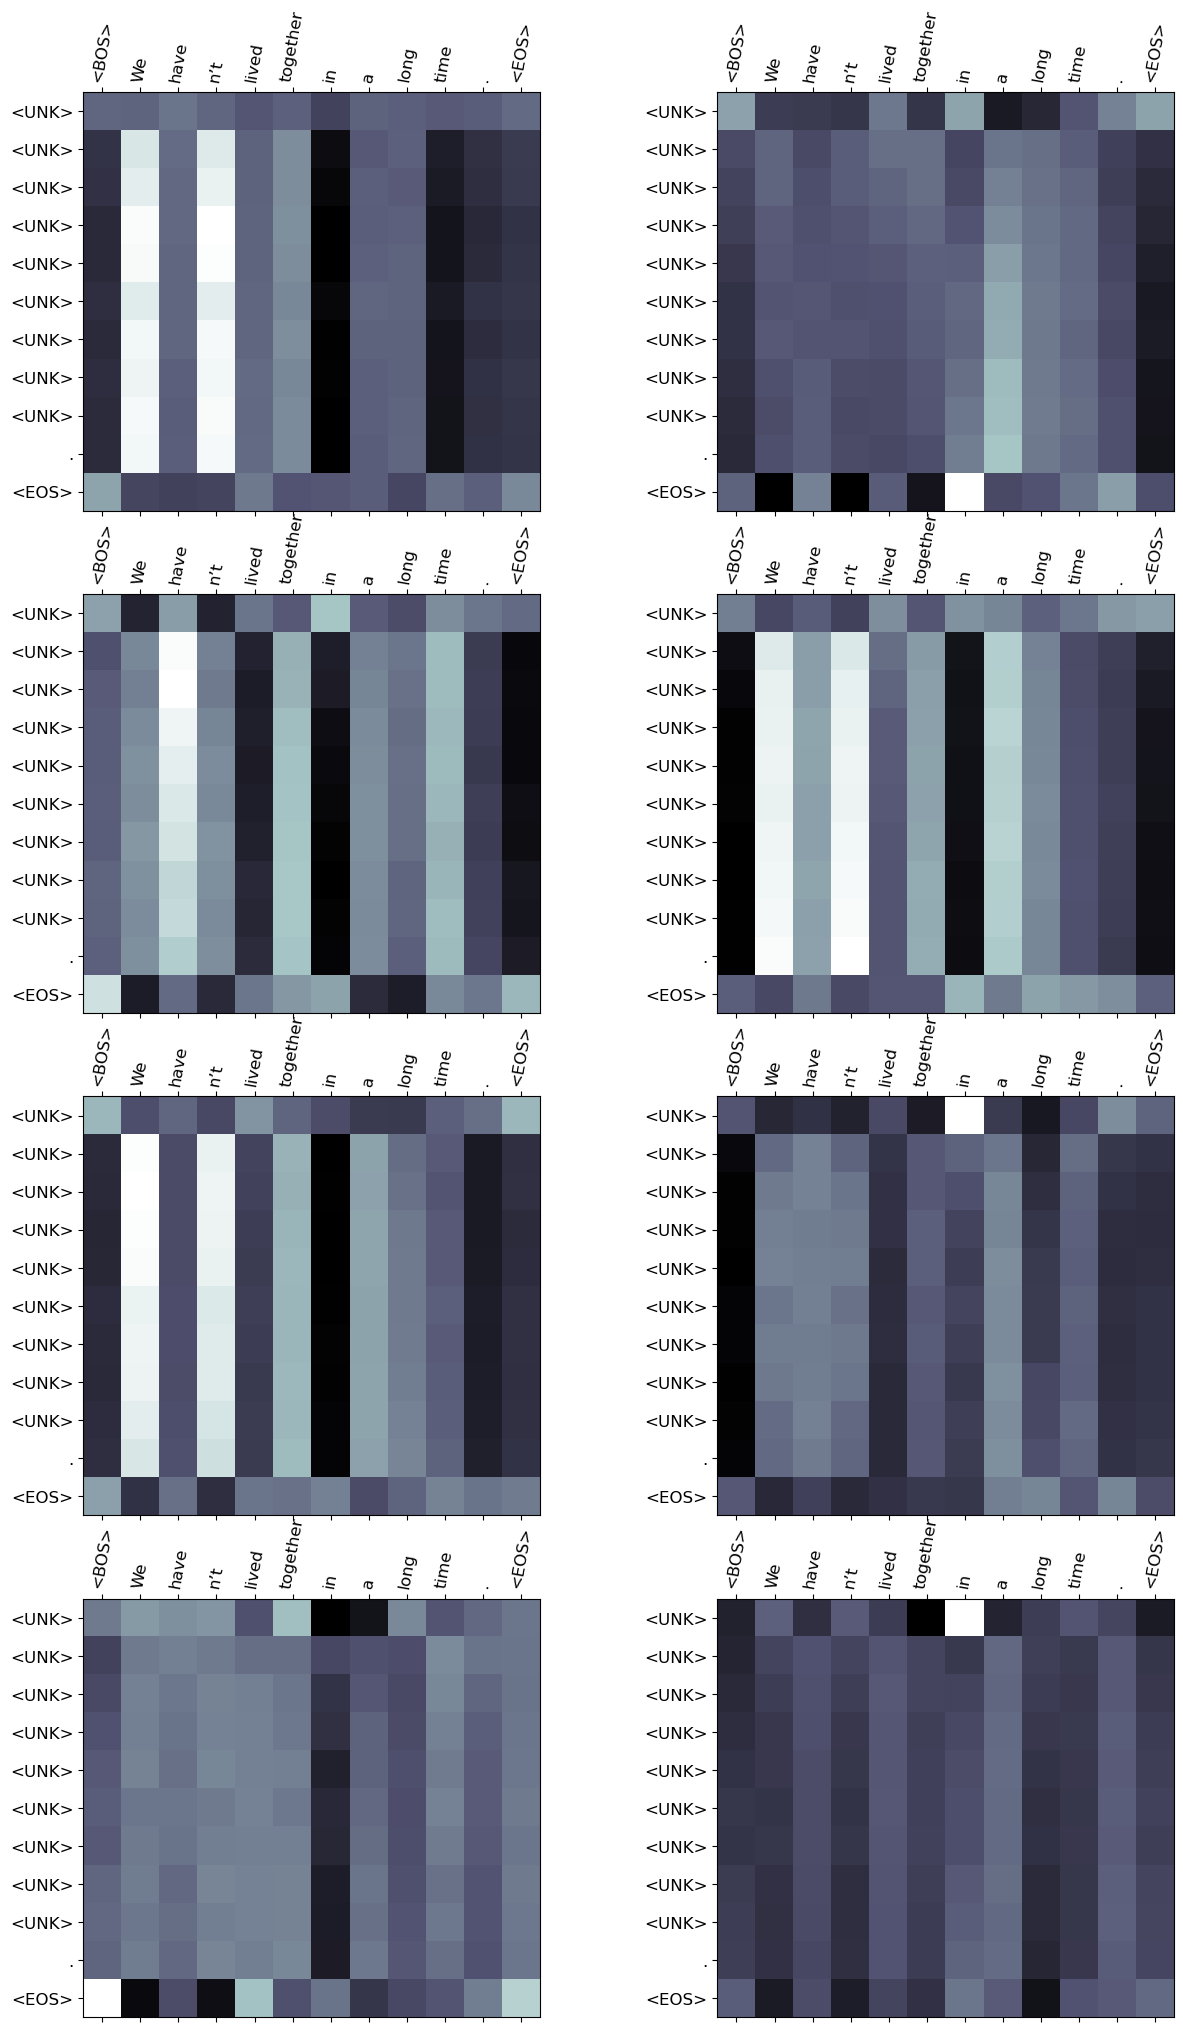

CPU times: total: 719 ms
Wall time: 725 ms


'. <EOS>'

In [62]:
%%time

src = 'We haven’t lived together in a long time.'
trg = 'Мы давно не живем вместе.'

print(f'src = {src}')
print(f'trg = {trg}')
print()

evaluateAndShowAttention(src, model, SRC, TRG, displayAttention=True, device=device, max_tokens=40,
                         return_hypotheses_n=1, beamsize=5)